<a href="https://colab.research.google.com/github/WeyoriJoshua/Projects/blob/main/hybrid_Speech_Enhancement_Tensorflow_UNet_Softmask_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tariqblecher_ravdess_8k_path = kagglehub.dataset_download('tariqblecher/ravdess-8k')
tariqblecher_urban_sound_8k_path = kagglehub.dataset_download('tariqblecher/urban-sound-8k')
tariqblecher_speech_mask_model_path = kagglehub.dataset_download('tariqblecher/speech-mask-model')

print('Data source import complete.')


100%|██████████| 43.1M/43.1M [00:00<00:00, 92.3MB/s]

Extracting files...


100%|██████████| 378M/378M [00:04<00:00, 88.1MB/s]

Extracting files...


100%|██████████| 20.7M/20.7M [00:00<00:00, 94.0MB/s]

Extracting files...


Data source import complete.


**Speech Enhancement Algorithm based on Tensorflow and Keras
**

**Data**
I mixed clean speech data from RAVDESS dataset with noise data from the UrbanSound8K dataset. As tensorflow was unable to read the raw files, I rewrote the original datasets locally and uploaded them back onto Kaggle. I also downsampled the datasets back to 8K - this captures most of the Speech signal.


This is quite a limited dataset for speech enhancement. My goal for this project was primarily to check how well this algorithm generally to a completely different unseen dataset.

**ALGORITHM**
This algorithm takes an Short Time Fourier Transform (STFT) of the audio files to return the transformed signal as a 2D array of dimensions time and frequency. The transformed signal is complex, but the algorithm only operates on the amplitude. The amplitude is passed through a softmask + UNet algorithm. This is a re-worked version from https://github.com/karolzak/keras-unet where I added the softmask component.  

**Loss Function**

I started with just an MSE loss between the clean speech amplitude and the reconstructed speech amplitude, however, this had the problem that it treated keeping noise equivalent to losing speech. As it is much more important to keep speech than to reduce noise, I created a custom loss function which features both a MSE term and another term which focuses specifically on

**METRIC**
The PESQ metric is used in the industry as an automatic way to measure speech quality. It is not without it's problems but it still works as a first pass. I would advise you to listen to the output files (clean, corrupted and corrected) to get a better sense of how the algorithm performs.

**Unseen data test**
In the Notebook below I test the model on a completely different dataset featuring 150+ different english accents mixed with hospital noise.
https://www.kaggle.com/tariqblecher/speech-enhancement-unseen-data-test

**Results**
On the validation data, we saw an average increase of +0.44 in the PESQ score (from 2.08 to 2.52)
In the unseen test data, we saw an average increase of +0.17 in the PESQ score (from 2.13 to 2.30)

Please cite this notebook if you use it.

**contact** : tariq.blecher@gmail.com

# Imports

In [3]:
!pip install pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262951 sha256=f63fdd6eb46f164e3ceb64e00c42bb39e234f8c30e58fb91adc6dda0f29c29bd
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


In [4]:
!pip install tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 9.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
from pesq import pesq
import soundfile as sf

# Load Data and Preprocess

In [6]:
sr=8000
speech_length_pix_sec=27e-3
total_length = 3.6
trim_length = 28305
n_fft=255
frame_length=255
frame_step = 110

noisefiles = glob.glob('/content/drive/MyDrive/urbansound_8k/*.wav')
files= glob.glob('/content/drive/MyDrive/ravdess_rewritten_8k/*.wav')
print(len(files),'clean data files')
print('Should be similar value to trim length', total_length*sr,trim_length)
print('Should be similar value to n_fft',n_fft, int(speech_length_pix_sec*sr))

@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=sr)
    return wav

@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    return wav

@tf.function
def white_noise(data,factor=0.03):
    noise_amp = factor*tf.reduce_max(data)*tf.random.normal(shape=(1,))
    corr_data = data + noise_amp*tf.random.normal(shape=tf.shape(data))
    return corr_data, data

@tf.function
def urban_noise(corr_data, data, factor=0.4,sr=sr):
    noisefile = tf.gather(noisefiles,tf.random.uniform((),0, len(noisefiles)-1,dtype=tf.int32))
    noisefile  = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data)/tf.reduce_max(noisefile) + corr_data
    return mixed, data

@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    return spectrogram_corr, spectrogram

@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram

@tf.function
def augment(spectrogram_corr, spectrogram):
    spectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, 10)
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, 20)
    return spectrogram_corr, spectrogram

@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

1440 clean data files
Should be similar value to trim length 28800.0 28305
Should be similar value to n_fft 255 216


In [7]:
batch_size=16
train_val_split_ratio = 0.2
split_index = int(len(files)*train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    if not train:
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

    if train:
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(batch_size)
        dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset
train_dataset = configure_dataset(train_files)
val_dataset = configure_dataset(val_files)

# Create and Run Model

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
    Flatten,  # For CNN integration
    Dense,  # For CNN integration
    Reshape # Import Reshape
)
#Import metrics
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError

class SNRMetric(tf.keras.metrics.Metric):
       def __init__(self, name='snr', **kwargs):
           super(SNRMetric, self).__init__(name=name, **kwargs)
           self.snr_sum = self.add_weight(name='snr_sum', initializer='zeros')
           self.count = self.add_weight(name='count', initializer='zeros')

       def update_state(self, y_true, y_pred, sample_weight=None):
           # Calculate SNR for each sample in the batch
           signal = y_true  # Clean signal
           noise = y_pred - y_true # Estimated noise (denoised - clean)
           snr = 10 * tf.math.log(tf.reduce_sum(signal**2, axis=-1) / (tf.reduce_sum(noise**2, axis=-1) + 1e-8)) / tf.math.log(10.0) # Add small epsilon to avoid division by zero

           # Update the sum and count
           self.snr_sum.assign_add(tf.reduce_sum(snr))
           self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

       def result(self):
           # Calculate the average SNR
           return self.snr_sum / self.count

       def reset_states(self):
           self.snr_sum.assign(0.)
           self.count.assign(0.)


def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def attention_gate(inp_1, inp_2, n_intermediate_filters):
    """Attention gate. Compresses both inputs to n_intermediate_filters filters before processing.
       Implemented as proposed by Oktay et al. in their Attention U-net, see: https://arxiv.org/abs/1804.03999.
    """
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    """Performs concatenation of upsampled conv_below with attention gated version of skip-connection
    """
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])


def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c


def custom_unet(
    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",  # 'deconv' or 'simple'
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=16,
    num_layers=4,
    output_activation="sigmoid",
    cnn_filters=64,  # Number of filters in the CNN layers
    cnn_dense_units=128,  # Number of units in the dense layer
):  # 'sigmoid' or 'softmax'

    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    x = inputs

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2  # double the number of filters with each layer

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2  # decreasing number of filters with each layer
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    # U-Net output (segmentation mask)
    output_mask = Conv2D(num_classes, (1, 1), activation=output_activation)(x)

    # CNN Integration
    reshape_output = Reshape((-1, filters))(x) # filters is the number of filters in the last conv2d_block
    flatten = Flatten()(reshape_output) # Flatten the reshaped output
    cnn = Dense(cnn_dense_units, activation='relu')(flatten)
    cnn = Dropout(0.5)(cnn)  # Add dropout for regularization
    cnn_output = Dense(num_classes, activation='sigmoid')(cnn)  # Output layer

    # Combine U-Net and CNN outputs (e.g., using element-wise addition)
    outputs = add([output_mask, cnn_output])

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the hybrid model
model = custom_unet(input_shape=(256, 128, 1), cnn_filters=64, cnn_dense_units=128)

# Compile and train the model with metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanSquaredError(), MeanAbsoluteError(),SNRMetric()])  # Include metrics here

# Assign the fit output to 'history' to capture training metrics.
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset)

# Access and print the metrics
mse = history.history['mean_squared_error']
mae = history.history['mean_absolute_error']
val_mse = history.history['val_mean_squared_error']
val_mae = history.history['val_mean_absolute_error']

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 629s 8s/step - loss: 2.8040 - mean_absolute_error: 0.6040 - mean_squared_error: 0.6064 - snr: -inf - val_loss: 3.0372 - val_mean_absolute_error: 0.6611 - val_mean_squared_error: 0.9107 - val_snr: -inf
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 555s 8s/step - loss: 0.8583 - mean_absolute_error: 0.4532 - mean_squared_error: 0.3256 - snr: -inf - val_loss: 1.1641 - val_mean_absolute_error: 0.4247 - val_mean_squared_error: 0.5203 - val_snr: -inf
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 563s 8s/step - loss: 0.8827 - mean_absolute_error: 0.4354 - mean_squared_error: 0.3050 - snr: -inf - val_loss: 1.3149 - val_mean_absolute_error: 0.4482 - val_mean_squared_error: 0.5463 - val_snr: -inf
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 542s 7s/step - loss: 0.8144 - mean_absolute_error: 0.4128 - mean_squared_error: 0.2766 - snr: -inf - val_loss: 1.7995 - val_mean_absolute_error: 0.5077 - val_mean_squared_error: 0.6316 - val_snr: -inf
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 546s 8

In [9]:
model = custom_unet(
    input_shape=(256, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=16,
    num_layers=4,
    dropout=0.2,
    output_activation='sigmoid',
    # CNN parameters
    cnn_filters=64,
    cnn_dense_units=128,
)

In [19]:
# Assuming this is the intended structure of your custom loss function:
def signal_enhancement_loss(y_true, y_pred):
    # Your loss function logic here. Example:
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    # Add any additional terms or logic for speech enhancement
    return mse_loss # Add this line to return the calculated loss

In [20]:
model.compile(optimizer='adam', loss=signal_enhancement_loss, metrics=[MeanSquaredError(), MeanAbsoluteError()])

In [21]:
model_filename = 'model_weights.weights.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True
)

callback_early_stop =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    mode="auto",
    restore_best_weights=True,
)

# Run Model
(Commented out as I am reading in a previously run model)

# Inspect Results

In [22]:
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test,train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array =  np.zeros((len(files_to_test),trim_length))
wav_corrupt_array =  np.zeros((len(files_to_test),trim_length))
wav_correct_array =  np.zeros((len(files_to_test),trim_length))
spec_clean_array=  np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array=  np.zeros((len(files_to_test), 256, 128))
spec_correct_array=  np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))




In [23]:
test_dataset = configure_dataset(files_to_test, train=False)
# ... other evaluation code

In [24]:
for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = np.abs(corr)
    corrected_amp = model.predict(np.expand_dims(corr_amp,0))
    corrected_spec = corrected_amp * np.exp(1j*np.angle(np.expand_dims(corr,0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

    # Convert tensors to NumPy arrays and squeeze to 1D
    # Changed 'wb' to 'nb' for narrowband mode as sr=8000
    pesq_with_noise[ind] = pesq(sr, clean_wav.numpy().squeeze(), corr_wav.numpy().squeeze(), 'nb')
    pesq_denoised[ind] = pesq(sr, clean_wav.numpy().squeeze(), corrected_wav.numpy().squeeze(), 'nb')

    wav_clean_array[ind] = clean_wav
    wav_corrupt_array[ind] = corr_wav
    wav_correct_array[ind] = corrected_wav
    spec_clean_array[ind] = np.abs(clean[:,:,0])
    spec_corrupt_array[ind] = np.abs(corr[:,:,0])
    spec_correct_array[ind] = corrected_amp[0,:,:,0]
    loss_with_noise[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean), corr_amp)).numpy()
    loss_denoised[ind] =tf.reduce_mean(signal_enhancement_loss(np.abs(clean[:,:,0]), corrected_amp[0,:,:,0])).numpy()

pesq_diff = pesq_denoised - pesq_with_noise

print(np.mean(pesq_with_noise), np.mean(pesq_denoised),pesq_diff.mean())

f'{np.mean(pesq_with_noise):.2f}, {np.mean(pesq_denoised):.2f}'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

'1.71, 1.25'

In [25]:
os.system('rm -r val_results')

256

In [26]:
results_dir = 'val_results'
os.mkdir(results_dir)

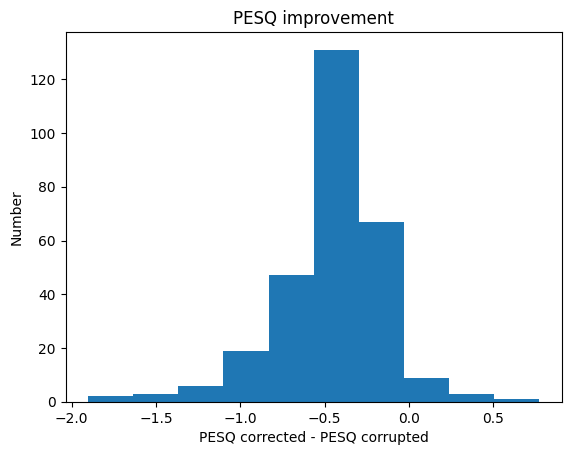

In [27]:
fig = plt.figure()
plt.title('PESQ improvement')
plt.hist(pesq_diff);
plt.xlabel('PESQ corrected - PESQ corrupted')
plt.ylabel('Number')
fig.savefig(results_dir+'/pesq_hist', bbox_inches='tight')

In [28]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
sf.write(results_dir +'/'+'clean_best_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_best_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_best_pesq_improvement.wav',wav_correct_array[ind],sr)

In [29]:
Audio(wav_clean_array[ind],rate=sr)

In [30]:
Audio(wav_corrupt_array[ind],rate=sr)

In [31]:
Audio(wav_correct_array[ind],rate=sr)

In [32]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
sf.write(results_dir +'/'+'clean_worst_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_worst_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_worst_pesq_improvement.wav',wav_correct_array[ind],sr)

In [33]:
Audio(wav_clean_array[ind],rate=sr)

In [34]:
Audio(wav_corrupt_array[ind],rate=sr)

In [35]:
Audio(wav_correct_array[ind],rate=sr)

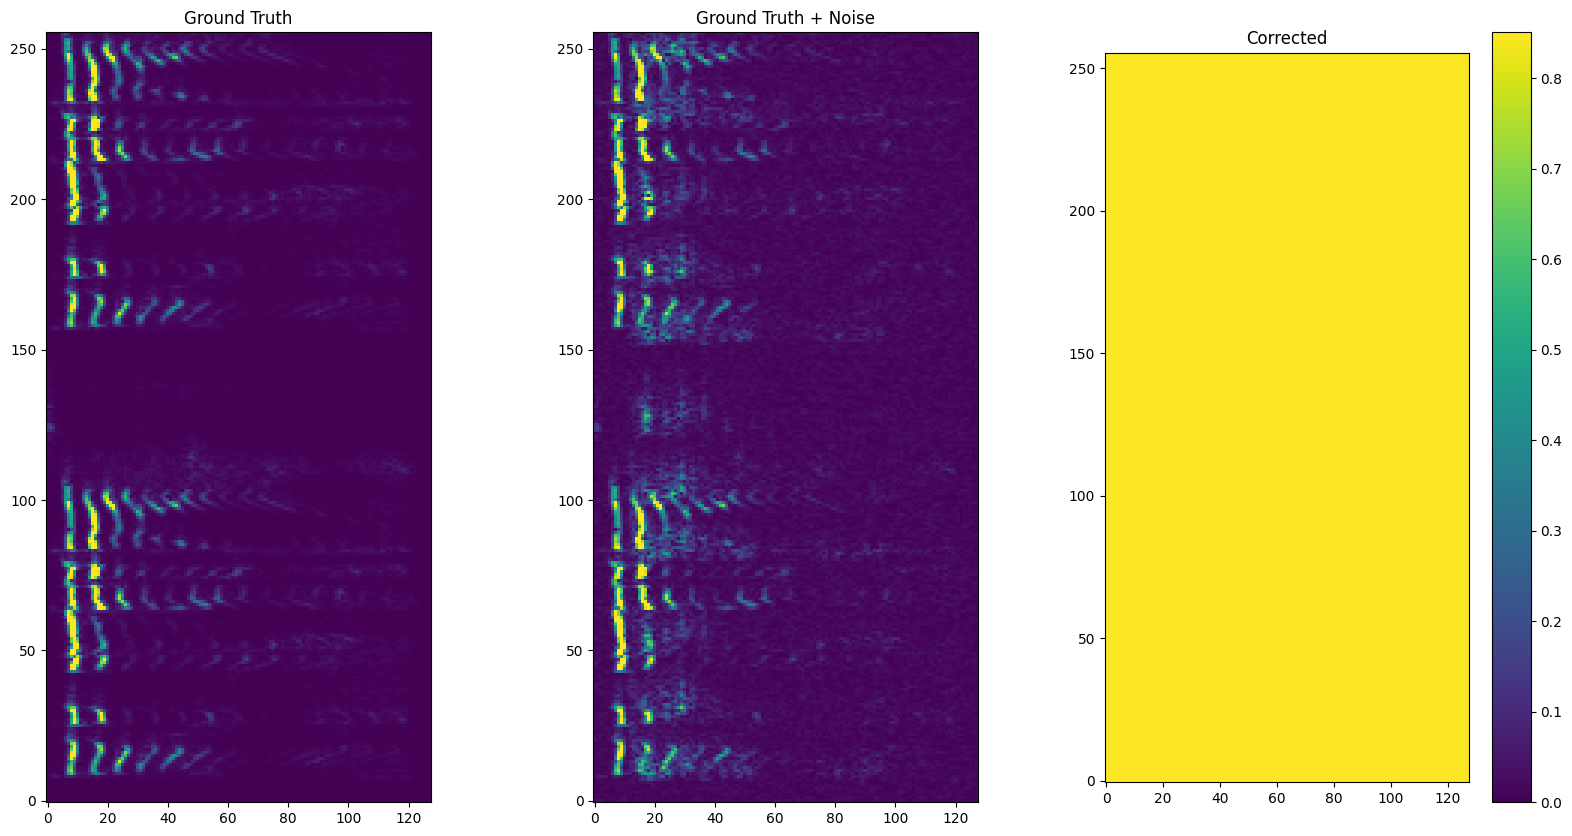

In [36]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/best_spec.png', bbox_inches='tight')

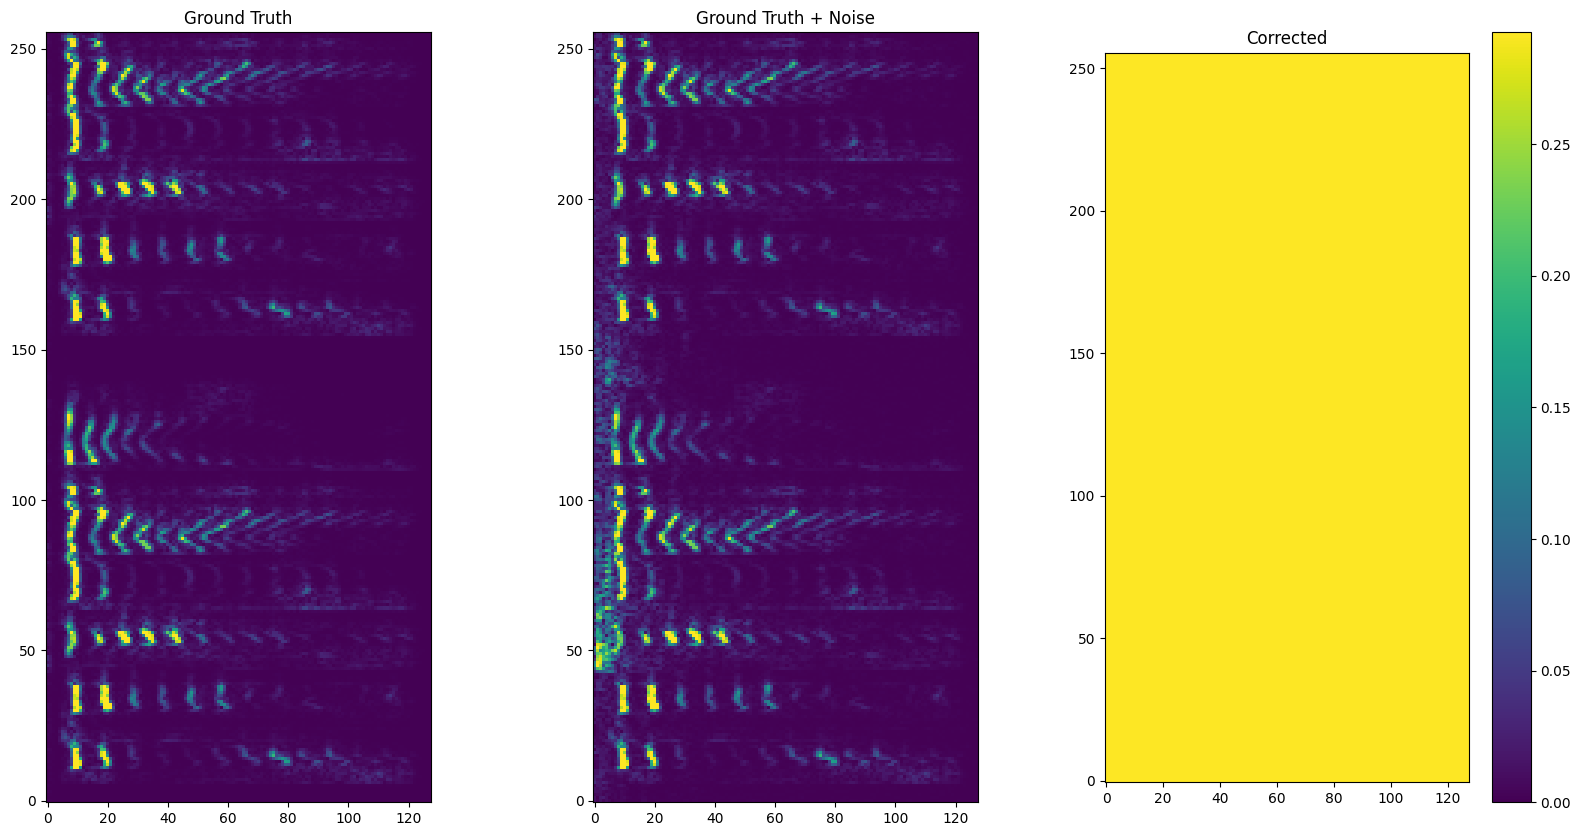

In [37]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/worst_spec.png', bbox_inches='tight')

In [38]:
test_ = np.expand_dims(corr_amp,0)

In [39]:
%%timeit -n 50
test = model.predict(test_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [40]:
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')

0

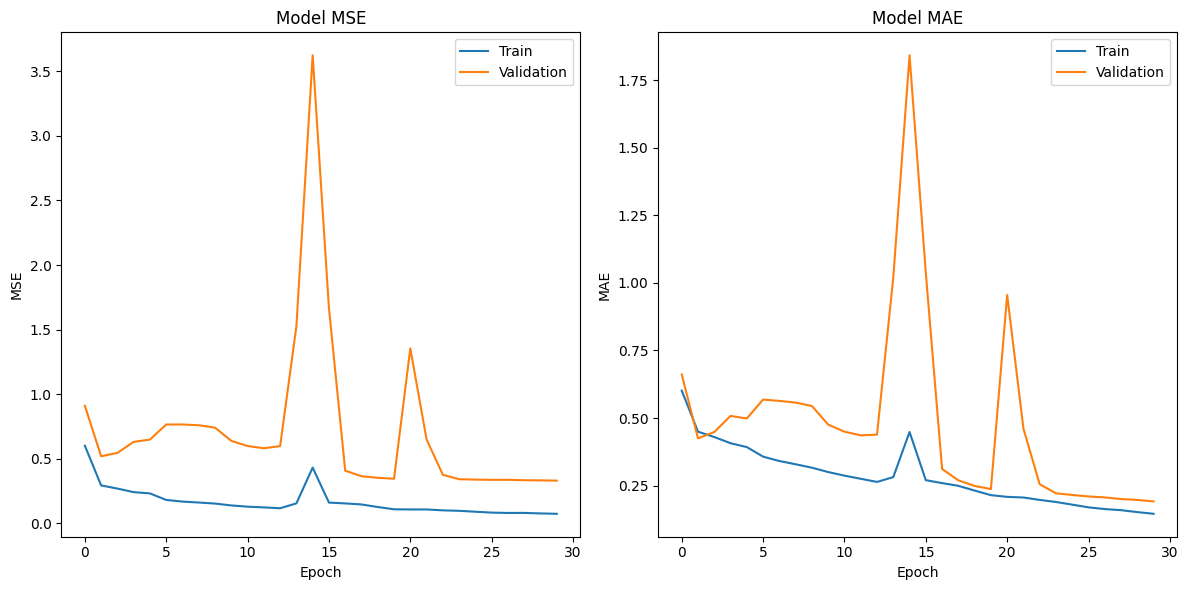

        loss  mean_absolute_error  mean_squared_error  snr   val_loss  \
0   2.867413             0.601206            0.601547 -inf   3.037211   
1   0.917053             0.449315            0.294398 -inf   1.164055   
2   0.908834             0.429595            0.270101 -inf   1.314893   
3   0.829094             0.406666            0.242568 -inf   1.799537   
4   0.847974             0.392418            0.232577 -inf   1.892921   
5   0.544954             0.357080            0.182122 -inf   2.641565   
6   0.506429             0.340828            0.169394 -inf   2.618889   
7   0.508888             0.328870            0.162030 -inf   2.653030   
8   0.497544             0.316167            0.154071 -inf   2.620099   
9   0.430812             0.300037            0.139527 -inf   1.732688   
10  0.395163             0.286776            0.129968 -inf   1.523494   
11  0.389170             0.275118            0.124333 -inf   1.514537   
12  0.371915             0.263513            0.1177

In [41]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# MSE plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# MAE plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# Create a pandas DataFrame from the history
metrics_df = pd.DataFrame(history.history)

# Display the DataFrame
print(metrics_df)

In [42]:
final_train_mse = history.history['mean_squared_error'][-1]
final_val_mse = history.history['val_mean_squared_error'][-1]
final_train_mae = history.history['mean_absolute_error'][-1]
final_val_mae = history.history['val_mean_absolute_error'][-1]

print(f"Final Training MSE: {final_train_mse:.4f}")
print(f"Final Validation MSE: {final_val_mse:.4f}")
print(f"Final Training MAE: {final_train_mae:.4f}")
print(f"Final Validation MAE: {final_val_mae:.4f}")

Final Training MSE: 0.0749
Final Validation MSE: 0.3316
Final Training MAE: 0.1456
Final Validation MAE: 0.1915
